## Naver Shopping Comments

- mecab을 활용한 텍스트 토크나이저 처리
- GRU 알고리즘 적용

In [1]:
# 필요한 패키지 import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# 말뭉치 파일 업로드하기
total_data = pd.read_table('naver_shopping.txt', names = ['ratings','reviews'])

In [3]:
# 전체 리뷰 개수 출력
print('전체 리뷰 개수: ', len(total_data))

전체 리뷰 개수:  200000


In [4]:
# 상위 5건 확인
total_data.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


ratings가 1,2,3이면 부정(label = 0)으로, 4,5면 긍정(label = 1)으로 구분한다.

In [5]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default = 0)
total_data.head()

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


## 데이터 전처리

In [6]:
# 데이터 전처리를 위한 컬럼별 중복을 제외한 값의 수 확인
print('ratings: ', total_data['ratings'].nunique())
print('reviews: ', total_data['reviews'].nunique())
print('label: ', total_data['label'].nunique())

ratings:  4
reviews:  199908
label:  2


- ratings열의 경우 1,2,4,5라는 네 가지 값
- reviews열에서 중복을 제외한 경우 199,908 =/= 200,000(원래 전체 리뷰 수)
    - 현재 20만개의 리뷰가 존재하므로 이는 현재 갖고 있는 데이터에 중복인 샘플들이 있다는 의미
- label열은 0과 1

In [7]:
# 중복되는 샘플 데이터를 제거
total_data.drop_duplicates(subset = ['reviews'], inplace = True)
print('총 샘플의 수: ', len(total_data))

총 샘플의 수:  199908


In [8]:
# 결측치(null값) 확인
total_data.isna().sum()

ratings    0
reviews    0
label      0
dtype: int64

In [9]:
# 훈련 데이터와 테스트 데이터를 3:1 비율로 분리
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 777)
print('훈련용 리뷰의 개수: ', len(train_data))
print('테스트용 리뷰의 개수: ', len(test_data))

훈련용 리뷰의 개수:  149931
테스트용 리뷰의 개수:  49977


In [10]:
# 훈련 데이터의 레이블 분포 확인
train_data.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,74922
1,1,75009


<AxesSubplot:>

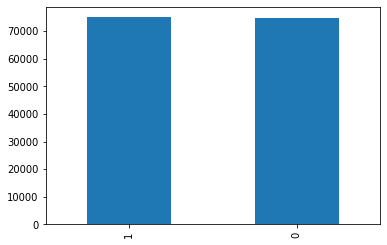

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
# train 데이터 정제
# -> 정규 표현식을 사용하여 한글을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '') # 한글이 아닌(^) 부분 모두 ''로 변경
train_data['reviews'].replace('', np.nan, inplace = True)

# 이 과정에서 빈 샘플이 생기지 않았는지 확인
train_data.isnull().sum()

<ipython-input-12-54705d92a626>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['reviews'] = train_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '') # 한글이 아닌(^) 부분 모두 ''로 변경
c:\users\youjin\appdata\local\programs\python\python38\lib\site-packages\pandas\core\series.py:4576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


ratings    0
reviews    0
label      0
dtype: int64

In [13]:
# test 데이터 정제
# -> 정규 표현식을 사용하여 한글을 제외하고 모두 제거
test_data['reviews'] = test_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '') # 한글이 아닌(^) 부분 모두 ''로 변경
test_data['reviews'].replace('', np.nan, inplace = True)

# 이 과정에서 빈 샘플이 생기지 않았는지 확인
test_data.isnull().sum()

<ipython-input-13-bc5aaa79b2f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['reviews'] = test_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '') # 한글이 아닌(^) 부분 모두 ''로 변경


ratings    0
reviews    0
label      0
dtype: int64

## Mecab

In [14]:
# 토큰화를 위한 불용어를 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [15]:
# 훈련데이터 토큰화
mecab = Mecab(dicpath=r'C:\mecab\mecab-ko-dic')
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)

# 토큰화 결과에서 불용어는 제거함
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

train_data.head()

<ipython-input-15-0992fc14e033>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
<ipython-input-15-0992fc14e033>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


,ratings,reviews,label,tokenized
67132,1,봉돌 비닐포장이 뜯어져서 왔네요 야광물질도 벗겨져 있구요ㅠ,0,"[봉돌, 비닐, 포장, 뜯, 어, 져서, 왔, 네요, 야, 광물질, 벗겨져, 있, ..."
48395,2,불편해요ㅡ다음엔 안살듯,0,"[불편, 해요, ㅡ, 다음, 엔, 안, 살]"
199169,2,직접보고 사지 않아서 일까요 크기가 많이 작네요지인집에서 의외의 씹는맛에 놀라고 오...,0,"[직접, 보, 사, 않, 아서, 일까요, 크기, 많이, 작, 요지, 집, 에서, 의..."
174898,2,일반욕조엔 맞는다고해서 샀는데 너무 꽉맞아서 아기가 물에 잠기지 않네요ㅠ 반송비가 ...,0,"[일반, 욕조, 엔, 맞, 는다고, 해서, 샀, 는데, 너무, 꽉, 맞, 아서, 아..."
28344,2,이 브랜드는 첨써보는데 끼워넣을때 좀 억지로넣어야되는 경향이있어요ㅜㅜ 제가못한건지 ...,0,"[브랜드, 첨, 써, 보, 데, 끼워, 넣, 때, 좀, 억지로, 넣, 어야, 되, ..."


In [29]:
# 테스트데이터 토큰화
mecab = Mecab(dicpath=r'C:\mecab\mecab-ko-dic')
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)

# 토큰화 결과에서 불용어는 제거함
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data.head()

<ipython-input-29-0696f9d058c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
<ipython-input-29-0696f9d058c1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


,ratings,reviews,label,tokenized
7636,4,잡기도 편하고 사용하기 좋아요,1,"[잡, 기, 편하, 사용, 기, 좋, 아요]"
38609,5,따듯하고 축구복안에입기좋아요,1,"[따듯, 축구, 복안, 입, 기, 좋, 아요]"
52630,5,재구매 화분보냈는데 잘자라고 가게분위기도확사네요 ㅎ,1,"[재, 구매, 화분, 보냈, 는데, 잘, 자라, 분위기, 확, 사, 네요, ㅎ]"
133487,1,항상 리얼테크닉제품을 사용하는데 이번엔 스폰지가 일정모양으로 전부 구겨져서 와서 복...,0,"[항상, 리얼, 테크닉, 제품, 사용, 데, 이번, 엔, 스폰지, 일정, 모양, 으..."
54914,1,토치로 쏘면 잠깐 불이 붙더니 금방 꺼집니다 하얗게 되는 시간도 오래 걸릴 뿐더러 ...,0,"[토치, 로, 쏘, 면, 잠깐, 불, 붙, 더니, 금방, 꺼집니다, 하얗, 되, 시..."


mecab이 실행이 되지 않을 때
- 압축파일 두 개 먼저 C:\mecab 폴더 만들어서 압축 풀어놓고
- 두 번째 압축파일에서 내 python version과 맞는 파일 mecab 폴더에 넣고
- pip install '파일 이름.whl'
- `mecab = Mecab(dicpath=r'C:\mecab\mecab-ko-dic')` 코드 실행(사전을 지정해주는 단계) 

## 단어와 길이 분포 확인하기
- 긍정 리뷰에는 주로 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산

#### 부정적 리뷰의 단어

In [24]:
# 1) 각 레이블에 따라서 별도로 단어들의 리스트를 저장
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
negative_words

array(['봉돌', '비닐', '포장', ..., '검수', '미흡', '함'], dtype='<U25')

In [22]:
# 2) Counter()를 사용하여 각 단어에 대한 빈도수를 카운트
negative_word_count = Counter(negative_words)
negative_word_count.most_common(20)

[('네요', 31841),
 ('는데', 20193),
 ('안', 19652),
 ('어요', 14817),
 ('있', 13263),
 ('너무', 13181),
 ('했', 11635),
 ('좋', 9726),
 ('배송', 9609),
 ('같', 9026),
 ('거', 8892),
 ('어', 8867),
 ('구매', 8822),
 ('아요', 8718),
 ('없', 8656),
 ('습니다', 8475),
 ('되', 8468),
 ('그냥', 8393),
 ('잘', 8095),
 ('않', 7965)]

#### 긍정적 리뷰의 단어

In [23]:
# 1) 각 레이블에 따라서 별도로 단어들의 리스트를 저장
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)
positive_words

array(['좋', '아요', '완전', ..., '좋', '았', '어요'], dtype='<U25')

In [26]:
# 2) Counter()를 사용하여 각 단어에 대한 빈도수를 카운트
positive_word_count = Counter(positive_words)
positive_word_count.most_common(20)

[('좋', 39383),
 ('아요', 21055),
 ('네요', 19880),
 ('잘', 18679),
 ('어요', 18640),
 ('구매', 16241),
 ('습니다', 13535),
 ('있', 12462),
 ('배송', 12147),
 ('는데', 11774),
 ('했', 9855),
 ('합니다', 9839),
 ('먹', 9632),
 ('재', 9340),
 ('너무', 8368),
 ('같', 7921),
 ('만족', 7310),
 ('거', 6602),
 ('어', 6396),
 ('쓰', 6379)]

긍정 리뷰의 평균 길이:  13.602141076404164
부정 리뷰의 평균 길이:  17.0584607992312


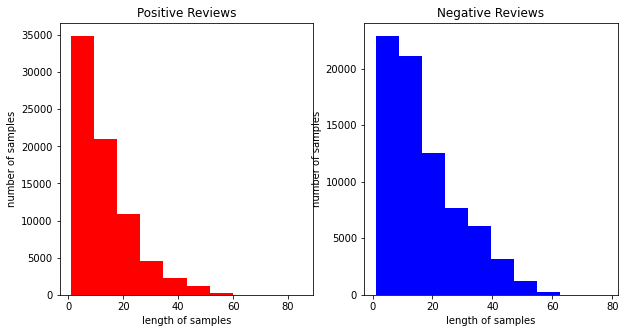

In [27]:
# 두 가지 경우에 대한 길이 분포 확인
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
text_len = train_data[train_data['label'] == 1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color = 'red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이: ', np.mean(text_len))

text_len = train_data[train_data['label'] == 0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color = 'blue')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이: ', np.mean(text_len))

- 부정 리뷰가 좀 더 길게 작성된 경향

In [31]:
# 정수 인코딩
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test = test_data['tokenized'].values
y_test = test_data['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [35]:
# 희귀 단어의 비율 알아보기
# -> 등장 빈도가 2회 미만인 단어
threshold = 2 # 제한하고자 하는 최대 등장 빈도수
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도구사 threshold보다 작은 단어의 등장 빈도수의 총합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기: ', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' %(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율: ', (rare_cnt/total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 ', (rare_freq/total_freq) * 100)

단어 집합(vocabulary)의 크기:  40083
등장 빈도가 1번 이하인 희귀 단어의 수: 18254
단어 집합에서 희귀 단어의 비율:  45.54050345533019
전체 등장 빈도에서 희귀 단어 등장 빈도 비율  0.7942264341565227


In [36]:
# 등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
# OOV --> Out of Vacabulary
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기: ', vocab_size)

단어 집합의 크기:  21831


In [37]:
# vocab_size를 토크나이저의 인자로 넘겨주면, 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# 정수 인코딩이 진행되었는지 확인하고자 X_train과 X_test에 대해서 상위 3개의 샘플만 출력
print(X_train[:3])
print(X_test[:3])

[[6787, 492, 78, 332, 17, 537, 70, 2, 314, 1, 2616, 8, 117, 95], [127, 50, 684, 192, 183, 10, 168], [634, 40, 64, 25, 43, 3355, 222, 62, 73, 1, 180, 68, 4219, 1145, 61, 2475, 1137, 937, 900, 36, 76, 38, 5, 299, 88, 73, 43, 10, 2717, 503, 48, 3310, 26, 4, 95]]
[[363, 23, 143, 30, 23, 3, 6], [2306, 5873, 1, 79, 23, 3, 6], [21, 9, 2087, 822, 5, 7, 4472, 1348, 1324, 64, 2, 153]]


리뷰의 최대 길이:  85
리뷰의 평균 길이:  15.32929814381282


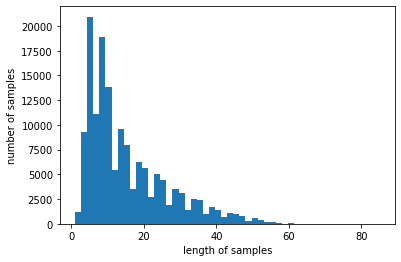

In [38]:
# 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포
print('리뷰의 최대 길이: ', max(len(l) for l in X_train))
print('리뷰의 평균 길이: ', sum(map(len, X_train)) / len(X_train))
plt.hist([len(s)for s in X_train], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [40]:
# 최대 길이가 85이므로 만약 80으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인
max_len = 80
cnt = 0

for x in X_train:
    if len(x) <= max_len:
        cnt += 1

result = (cnt / len(X_train)) * 100
print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' % (max_len, result))

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99866605305107


In [41]:
# 훈련용 리뷰를 길이 80으로 패딩
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## GRU로 네이버 쇼핑 리뷰 감성 분류
- GRU: LSTM의 간소화 형태


In [42]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [43]:
# 모델 구성
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation = 'sigmoid'))

In [45]:
# 콜백함수 지정
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [46]:
# 모델 컴파일
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2183100   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,271,549
Trainable params: 2,271,549
Non-trainable params: 0
_________________________________________________________________


In [47]:
# 훈련 시작
history = model.fit(X_train, y_train, epochs = 15, callbacks = [es, mc], batch_size = 60, validation_split = 0.2)

Epoch 1/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2694 - acc: 0.8986
Epoch 00001: val_acc improved from -inf to 0.92070, saving model to best_model.h5
2000/2000 [==============================] - 265s 132ms/step - loss: 0.2694 - acc: 0.8986 - val_loss: 0.2224 - val_acc: 0.9207
Epoch 2/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2132 - acc: 0.9231
Epoch 00002: val_acc improved from 0.92070 to 0.92313, saving model to best_model.h5
2000/2000 [==============================] - 271s 135ms/step - loss: 0.2132 - acc: 0.9231 - val_loss: 0.2119 - val_acc: 0.9231
Epoch 3/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1970 - acc: 0.9297
Epoch 00003: val_acc improved from 0.92313 to 0.92550, saving model to best_model.h5
2000/2000 [==============================] - 271s 136ms/step - loss: 0.1970 - acc: 0.9297 - val_loss: 0.2057 - val_acc: 0.9255
Epoch 4/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1868 - acc: 0.

In [48]:
# 훈련 정확도 확인
loaded_model = load_model('best_model.h5')
print('\n 테스트 정확도: %.4f' % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 31s 20ms/step - loss: 0.2099 - acc: 0.9252

 테스트 정확도: 0.9252


## 리뷰 예측해보기

In [49]:
def sentiment_predict(new_sentence):
    new_sentence = mecab.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불영어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if (score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [50]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')
sentiment_predict('판매자님... 너무 짱이에요.... 대박나삼')
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄹ리뷰쓰기도 귀찮아')

97.63% 확률로 긍정 리뷰입니다.
99.63% 확률로 부정 리뷰입니다.
97.45% 확률로 긍정 리뷰입니다.
92.33% 확률로 부정 리뷰입니다.
